# Modeling - Baseline Model

**Author:** Joel Klein, Jacob Sauberman, Ben Perkins

**Date:** December 7, 2021

**Description:** This script loads in MLB Statcast data from every MLB registered pitch since 2017, prepares the pitch data, and then passes in the pitch data to a fully connected neural network to predict the next pitch type. This script includes the neural network modeling with the current game state, and the historical pitcher/hitter statistics input features. 

**Data:** The data is scraped from *baseballsavant.com* for each year and combined together in one large data file. 

**Scope:** To avoid data leakage, the data can not be randomly split across all years in the training, validation, and test sets. Future pitches cannot be included as inputs within the training data to generate predictions for past pitches in the validation and/or test data. The data from the 2017 and 2018 seasons will be used for training data while the 2019 season is used for validation. 2020 and 2021 seasons will be used for the testing data in the next pitch prediction model. 

There are many instances in major league baseball where rookie batters and pitchers receive at-bats and there is little or no prior pitch sequence data. In order to make a prediction on next pitch types in the 2019, 2020, and 2021 seasons, the batter and the pitcher need to have a significant amount of recorded at-bats in the 2017 and 2018 seasons. Only batters and pitchers accounting for 90% of at-bats in the 2017 and 2018 seasons were included in scope (441 batters and 512 pitchers) for generating the pitcher and batter embeddings.

**Notes:** 

**Warnings:** 

**Outline:** 
  - Install Libraries
  - Global Options
  - Set Directories
  - Define Functions
  - Load Data
  - Data Preparation
  - Data Splitting
  - Data Loaders
  - Train Model
  - Evaluation

## Import Libraries

Let's load in the python libraries needed for the this notebook.

In [1]:
# data manipulation
import numpy as np
import pandas as pd 
import os
import zipfile

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import plotly.express as px

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch import cuda
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence

# splitting data
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder

# pipelines
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

# random number generator
import random

# other
import IPython
import pickle
from os import listdir
from os.path import isfile, join

# pybaseball
!pip install pybaseball
from pybaseball import playerid_reverse_lookup

     |████████████████████████████████| 415 kB 14.9 MB/s 
     |████████████████████████████████| 291 kB 67.4 MB/s 
     |████████████████████████████████| 961 kB 63.6 MB/s 


## Global Options

Let's set a few global options for the notebook

In [2]:
# do not show warnings
import warnings
warnings.filterwarnings('ignore')

# set pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 2000)
pd.options.display.float_format = '{:.5f}'.format

## Set Directories

Let's set the directories needed to load in the data into the notebook.

In [3]:
# mount data drive on colab
from google.colab import drive
drive.mount('/content/drive')

# set folder directories to load and save data
DATA_DIR = "/content/drive/MyDrive/final-project-dl/data"
STATCAST_DATA_DIR = "/content/drive/MyDrive/final-project-dl/data/statcast"
EMBEDDINGS_DATA_DIR = "/content/drive/MyDrive/final-project-dl/data/embeddings"

Mounted at /content/drive


## Define Functions

All custom functions needed in the notebook are listed in this section.

In [4]:
##### Define data loading function ----

# define a function for loading in dataset
def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    
    return df

In [5]:
##### Define early stopping class -----

# source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
# date accessed: 2021-12-08

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Load Data

Let's load in the pitch data from the 2017, 2018, 2019, 2020, and 2021 seasons via the train, validation, and test sets.

In [6]:
# load in each dataset
train_data = load_data(os.path.join(STATCAST_DATA_DIR, 'train_data.csv'), 'train_data')
validation_data = load_data(os.path.join(STATCAST_DATA_DIR, 'validation_data.csv'), 'validation_data')
test_data = load_data(os.path.join(STATCAST_DATA_DIR, 'test_data.csv'), 'test_data')

train_data: shape is (785777, 107)
validation_data: shape is (344941, 107)
test_data: shape is (267635, 107)


Let's load in the batter and pitcher embeddings

In [7]:
# load in batter embeddings reference table
with open(os.path.join(EMBEDDINGS_DATA_DIR, 'batter_embedding_df.pkl'), 'rb') as f:
    batter_embedding_df = pickle.load(f)

# load in pitcher embeddings reference table
with open(os.path.join(EMBEDDINGS_DATA_DIR, 'pitcher_embedding_df.pkl'), 'rb') as f:
    pitcher_embedding_df = pickle.load(f)

## Data Preparation

#### Recategorize previous outcome to smaller class

In [8]:
train_data['prev_outcome'] = np.select(
    [
      train_data['prev_description'].isin(["ball", "blocked_ball"]), 
      train_data['prev_description'].isin(["foul", "foul_tip"]),
      (train_data['prev_description'] == "hit_into_play") & ~train_data['prev_events'].isin(["single", "double", "triple", "home_run"]),
      (train_data['prev_description'] == "hit_into_play") & ~train_data['prev_events'].isin(["single", "double", "triple", "home_run"]),
      train_data['prev_description'] == "called_strike",
      train_data['prev_description'].isin(["swinging_strike", "swinging_strike_blocked"])
    ], 
    [
      'ball', 
      'foul',
      'out',
      'hit',
      'called_strike',
      'swinging_strike'
    ], 
    default='other'
)

validation_data['prev_outcome'] = np.select(
    [
      validation_data['prev_description'].isin(["ball", "blocked_ball"]), 
      validation_data['prev_description'].isin(["foul", "foul_tip"]),
      (validation_data['prev_description'] == "hit_into_play") & ~validation_data['prev_events'].isin(["single", "double", "triple", "home_run"]),
      (validation_data['prev_description'] == "hit_into_play") & ~validation_data['prev_events'].isin(["single", "double", "triple", "home_run"]),
      validation_data['prev_description'] == "called_strike",
      validation_data['prev_description'].isin(["swinging_strike", "swinging_strike_blocked"])
    ], 
    [
      'ball', 
      'foul',
      'out',
      'hit',
      'called_strike',
      'swinging_strike'
    ], 
    default='other'
)

test_data['prev_outcome'] = np.select(
    [
      test_data['prev_description'].isin(["ball", "blocked_ball"]), 
      test_data['prev_description'].isin(["foul", "foul_tip"]),
      (test_data['prev_description'] == "hit_into_play") & ~test_data['prev_events'].isin(["single", "double", "triple", "home_run"]),
      (test_data['prev_description'] == "hit_into_play") & ~test_data['prev_events'].isin(["single", "double", "triple", "home_run"]),
      test_data['prev_description'] == "called_strike",
      test_data['prev_description'].isin(["swinging_strike", "swinging_strike_blocked"])
    ], 
    [
      'ball', 
      'foul',
      'out',
      'hit',
      'called_strike',
      'swinging_strike'
    ], 
    default='other'
)

### Data Integration

The batters and pitchers will be passed in as embedding vectors into the model, which is a lower dimensional representation. We will join the batter and pitcher columns from the original data to the embedding vectors we loaded in earlier.

In [9]:
# get the list of the batter column names from the embedding data frame
batter_cols = list(['batter_' + str(i) for i in range(9)]) # these are 9 dimensional embeddings
batter_cols.append('batter')

# get the list of the pitcher column names from the embedding data frame
pitcher_cols = list(['pitcher_' + str(i) for i in range(9)]) # these are 9 dimensional embeddings
pitcher_cols.append('pitcher')

In [10]:
##### Batter Embedding Integration ----

## Train --

# get the existing statcast data row count
train_data_nrow = len(train_data)

# join the batter embeddings to the data
train_data = train_data.merge(batter_embedding_df[batter_cols], on='batter', how='left')

# get the new statcast data row count
train_data_batter_nrow = len(train_data)

# make sure the join doesn't produce duplicate records
print(train_data_nrow == train_data_batter_nrow)

## Validation --

# get the existing statcast data row count
validation_data_nrow = len(validation_data)

# join the batter embeddings to the data
validation_data = validation_data.merge(batter_embedding_df[batter_cols], on='batter', how='left')

# get the new statcast data row count
validation_data_batter_nrow = len(validation_data)

# make sure the join doesn't produce duplicate records
print(validation_data_nrow == validation_data_batter_nrow)

## Test --

# get the existing statcast data row count
test_data_nrow = len(test_data)

# join the batter embeddings to the data
test_data = test_data.merge(batter_embedding_df[batter_cols], on='batter', how='left')

# get the new statcast data row count
test_data_batter_nrow = len(test_data)

# make sure the join doesn't produce duplicate records
print(test_data_nrow == test_data_batter_nrow)

True
True
True


In [11]:
##### Pitcher Embedding Integration ----

## Train --

# get the existing statcast data row count
train_data_nrow = len(train_data)

# join the pitcher embeddings to the data
train_data = train_data.merge(pitcher_embedding_df[pitcher_cols], on='pitcher', how='left')

# get the new statcast data row count
train_data_pitcher_nrow = len(train_data)

# make sure the join doesn't produce duplicate records
print(train_data_nrow == train_data_pitcher_nrow)

## Validation --

# get the existing statcast data row count
validation_data_nrow = len(validation_data)

# join the pitcher embeddings to the data
validation_data = validation_data.merge(pitcher_embedding_df[pitcher_cols], on='pitcher', how='left')

# get the new statcast data row count
validation_data_pitcher_nrow = len(validation_data)

# make sure the join doesn't produce duplicate records
print(validation_data_nrow == validation_data_pitcher_nrow)

## Test --

# get the existing statcast data row count
test_data_nrow = len(test_data)

# join the pitcher embeddings to the data
test_data = test_data.merge(pitcher_embedding_df[pitcher_cols], on='pitcher', how='left')

# get the new statcast data row count
test_data_pitcher_nrow = len(test_data)

# make sure the join doesn't produce duplicate records
print(test_data_nrow == test_data_pitcher_nrow)

True
True
True


After the join, we need to remove features that are not needed for the training data.

In [12]:
# drop columns from data set we do not care about
train_data = train_data.drop(columns=['batter', 'pitcher', 'prev_game_pitch_number', 'prev_game_pitch_number', 'prev_game_pk', 'prev_pitch_number', 'prev_at_bat_number', 'game_pitch_number'])
validation_data = validation_data.drop(columns=['batter', 'pitcher', 'prev_game_pitch_number', 'prev_game_pitch_number', 'prev_game_pk', 'prev_pitch_number', 'prev_at_bat_number', 'game_pitch_number'])
test_data = test_data.drop(columns=['batter', 'pitcher', 'prev_game_pitch_number', 'prev_game_pitch_number', 'prev_game_pk', 'prev_pitch_number', 'prev_at_bat_number', 'game_pitch_number'])

In [13]:
# assign the input and response features
x_train = train_data.drop(['pitch_class'], axis = 1) # features
y_train = train_data['pitch_class'] # label

x_validation = validation_data.drop(['pitch_class'], axis = 1) # features
y_validation = validation_data['pitch_class'] # label

x_test = test_data.drop(['pitch_class'], axis = 1) # features
y_test = test_data['pitch_class'] # label

We need to convert the input features into an index before training.

In [14]:
# Assign each pitch with a unique index
pitch_to_ix = {"fourseam": 0, "twoseam": 1, "slider": 2,
               "changeup": 3, "curveball": 4, "cutter": 5}

# Convert the pitch code to the index for target data, y_train_df, y_valid_df
y_train = y_train.map(pitch_to_ix)
y_validation = y_validation.map(pitch_to_ix)
y_test = y_test.map(pitch_to_ix)

After checking for missing data after these transformations, we see there are still some of the previous pitch data features which are missing. These represent the first pitches of the game and so there is no previous pitch information. These features will be imputed with a 0 when passed into the model.

In [15]:
##### Missing Data Check ----

# game state data
percent = (x_train.isnull().sum()/x_train.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = x_train.isna().sum().sort_values(ascending = False)
missing_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
display(missing_data[missing_data['Percent'] != 0])

,Percent,Train Missing Count
prev_hc_x,82.95000,651819
prev_hc_y,82.95000,651819
prev_launch_speed_angle,82.89000,651364
prev_bb_type,82.68000,649651
prev_events,74.83000,587991
prev_hit_distance_sc,73.70000,579104
prev_release_spin_rate,1.97000,15500
prev_effective_speed,0.66000,5196
prev_release_extension,0.48000,3788
prev_release_speed,0.48000,3788


### Data Pipeline

To prepare the inputs and targets, we will first pass the input data into a preparation pipeline. The pipeline will impute missing categorical features with "Unknown" and one hot encode the features. All numeric features missing will be imputed with 0 and then scaled. We start by setting the features we will pass into the pipeline. The ID features are still needed so we can split the data by at bat and eventually pass that in as a sequence to the model.

In [16]:
# ohe and no imputation
categorical_features = ['outs_when_up',
                        'count',
                        'stand',
                        'p_throws',
                        'tto']

# numeric and impute with 0
numerical_features = ['recent_fourseam_usage',
                      'recent_twoseam_usage',
                      'recent_cutter_usage',
                      'recent_slider_usage',
                      'recent_curveball_usage',
                      'recent_changeup_usage',
                      'long_term_fourseam_usage',
                      'long_term_twoseam_usage',
                      'long_term_cutter_usage',
                      'long_term_slider_usage',
                      'long_term_curveball_usage',
                      'long_term_changeup_usage',
                      'Changeup_release_speed_m',
                      'Curveball_release_speed_m',
                      'Cutter_release_speed_m',
                      'Fourseam_release_speed_m',
                      'Slider_release_speed_m',
                      'Twoseam_release_speed_m',
                      'Changeup_release_spin_rate_m',
                      'Curveball_release_spin_rate_m',
                      'Cutter_release_spin_rate_m',
                      'Fourseam_release_spin_rate_m',
                      'Slider_release_spin_rate_m',
                      'Twoseam_release_spin_rate_m',
                      'Changeup_strike_per_m',
                      'Curveball_strike_per_m',
                      'Cutter_strike_per_m',
                      'Fourseam_strike_per_m',
                      'Slider_strike_per_m',
                      'Twoseam_strike_per_m',
                      'Changeup_whiff_per_m',
                      'Curveball_whiff_per_m',
                      'Cutter_whiff_per_m',
                      'Fourseam_whiff_per_m',
                      'Slider_whiff_per_m',
                      'Twoseam_whiff_per_m',
                      'Changeup_woba_value_m',
                      'Curveball_woba_value_m',
                      'Cutter_woba_value_m',
                      'Fourseam_woba_value_m',
                      'Slider_woba_value_m',
                      'Twoseam_woba_value_m',
                      'batter_Changeup_whiff_per_m',
                      'batter_Curveball_whiff_per_m',
                      'batter_Cutter_whiff_per_m',
                      'batter_Fourseam_whiff_per_m',
                      'batter_Slider_whiff_per_m',
                      'batter_Twoseam_whiff_per_m',
                      'batter_Changeup_woba_value_m',
                      'batter_Curveball_woba_value_m',
                      'batter_Cutter_woba_value_m',
                      'batter_Fourseam_woba_value_m',
                      'batter_Slider_woba_value_m',
                      'batter_Twoseam_woba_value_m',
                      'bat_score',
                      'fld_score',
                      'on_1b',
                      'on_2b',
                      'on_3b',
                      'pitch_number',
                      'pitcher_pitch_number']

We specify the pipeline below to perform the data transformations.

In [17]:
##### Data Pipelines ----

# create pipeline for numeric features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0.0)),
        ('std_scaler', StandardScaler()),
    ])

# create pipeline for numeric features
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value="NA")),
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary')),
    ])

# specify the column transformer for numeric features
data_pipeline = ColumnTransformer(
    [("num_pipeline", num_pipeline, numerical_features),
     ("cat_pipeline", cat_pipeline, categorical_features)],
    remainder='passthrough')

We will then apply the data transformation pipeline to the training, validation, and test data.

In [18]:
# convert categorical variables to strings
x_train[categorical_features] = x_train[categorical_features].astype(str) 

# apply the pipeline to the input data
x_train_transformed = data_pipeline.fit_transform(x_train[numerical_features + categorical_features])

# convert categorical variables to strings
x_validation[categorical_features] = x_validation[categorical_features].astype(str) 

# apply the pipeline to the validation data
x_validation_transformed = data_pipeline.transform(x_validation[numerical_features + categorical_features])

# convert categorical variables to strings
x_test[categorical_features] = x_test[categorical_features].astype(str) 

# apply the pipeline to the validation data
x_test_transformed = data_pipeline.transform(x_test[numerical_features + categorical_features])

In [19]:
# preview the transformed training data
display(x_train_transformed)

# print the shape of the training data
print(x_train_transformed.shape)

array([[-0.78042864,  0.58270307, -0.44229141, ...,  0.        ,
         0.        ,  0.        ],
       [-0.78042864,  0.58270307, -0.44229141, ...,  0.        ,
         0.        ,  0.        ],
       [-0.92705851,  0.73617727, -0.44229141, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.51357801, -0.03119376,  5.68341187, ...,  0.        ,
         0.        ,  0.        ],
       [-1.51357801, -0.18466797,  5.9497468 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.51357801, -0.18466797,  5.9497468 , ...,  0.        ,
         0.        ,  0.        ]])

(785777, 83)


A custom class needs to be created to enable pytorch to pass in both the input arrays and output labels.

In [20]:
# create a custom class to return tensors that will be inputs into deep learning model
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = torch.FloatTensor(X_data)
        self.y_data = torch.LongTensor(y_data)
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

A batch size of 2000 is set for the training data loader to apply optimization and backpropogating the loss at each epoch. The validation and test data loader is set to the full size to estimate the out-of-sample loss.

In [21]:
#### Data Loaders ----

# set batch size
BATCH_SIZE = 2000

# return tensors
train_data = CustomDataset(x_train_transformed, y_train)

# return tensors
validation_data = CustomDataset(x_validation_transformed, y_validation)

# return tensors
test_data = CustomDataset(x_test_transformed, y_test)

# set training data loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# set validation data loader
validation_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# set test data loader
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False, num_workers=0)

### Train Baseline Fully Connected Neural Network

This code leverages wrappers of pytorch to perform model training and evaluation. The series of training and evaluation functions below enable the training and evaluation to be executed with one line of code later on in the section.

In [22]:
#### Define training functions ----

# define function to train a model at each epoch and return train loss and accuracy
def train_epoch(epoch, clf, criterion, opt, data_loader, printlog=False, printnum=1):

  """Train pytorch model and collect training results
  
  Keyword arguments:
  
  epoch -- number of epochs
  clf -- torch nn module
  criterion -- loss function
  opt -- torch optimizer function
  data_loader -- torch train data loader
  printlog -- indicator to print the training loss and accuracy (default=False)
  printnum -- number of epochs run to print the loss
  """

  # training mode
  clf.train()

  # reset train_loss, correct predictions, and predictions
  correct = 0.0
  n = 0.0
  train_loss = 0.0

  # training via batching
  for batch_id, data in enumerate(data_loader):
      
      # load in input and target data in batch
      inputs, target = data[0].to(device), data[1].to(device)
      
      # predict the train data
      y_pred = clf(inputs)
      
      # calculate loss
      loss = criterion(y_pred, target)
      
      # zero the gradient
      opt.zero_grad()

      # backpropogation
      loss.backward()
      
      # update model weights
      opt.step()

      # append loss stat
      train_loss += loss.item()

      # returns class prediction
      pred_class = torch.max(y_pred.data, 1)[1]

      # number of correct predictions
      correct += (pred_class == target).sum().item()
        
      # append number of predictions made
      n += target.size(0)

  # print run stats at end of each epoch for average loss, accuracy
  if (printlog == True) & (epoch % printnum == 0):
    print(f'Epoch {epoch}: | Train Loss: {train_loss/len(data_loader):.5f} | Train Acc: {correct/n:.5f}')

  train_loss = train_loss/len(data_loader) # running loss
  train_accuracy = correct/n # train accuracy for epoch

  return clf, train_loss, train_accuracy

# define function to evaluate a model at each epoch and return test loss and accuracy
def evaluate_model(epoch, clf, criterion, opt, data_loader, printlog=False, printnum=1):

  """Evaluate pytorch model and collect test results
  
  Keyword arguments:
  
  epoch -- number of epochs
  clf -- torch nn module
  criterion -- loss function
  opt -- torch optimizer function
  data_loader -- torch test data loader
  printlog -- indicator to print the test loss and accuracy (default=False)
  printnum -- number of epochs run to print the loss
  """

  clf.eval() # set model in inference mode
  
  # set test_loss, correct predictions, and predictions
  test_loss = 0.0
  correct = 0.0
  n = 0.0

  with torch.no_grad():
    for i,data in enumerate(data_loader):
        
        # load in input and target data in batch
        inputs, target = data[0].to(device), data[1].to(device)

        # predict the test data
        y_pred = clf(inputs)
        
        # calculate loss
        loss = criterion(y_pred, target)
        
        # returns class prediction
        pred_class = torch.max(y_pred.data, 1)[1]
        
        # append loss stat
        test_loss += loss.item()
        
        # number of correct predictions
        correct += (pred_class == target).sum().item()
        
        # append test accuracy
        n += target.size(0)

  # print run stats at end of each epoch for average loss, accuracy
  if (printlog == True) & (epoch % printnum == 0):
    print(f'Epoch {epoch}: | Test Loss: {test_loss/len(data_loader):.5f} | Test Acc: {correct/n:.5f}')

  test_loss = test_loss/len(data_loader) # running loss
  test_accuracy = correct/n

  return test_loss, test_accuracy


##### Define training and evaluation function wrapper ----

# define a function to perform training given classifier, hidden layers, activation function, 
# initialization technique, and optimizer arguments
def train_and_evaluate(clf, opt, epochs, learning_rate, criterion, printlog, train_data_loader, test_data_loader, printnum):

  """Train and Evaluate pytorch deep neural network model given classifier, 
  number of hidden layers, activation function, weight initialization strategy, 
  and training parameters.
  
  Keyword arguments:
  
  clf -- torch nn module
  opt -- torch optimizer function
  epochs -- number of epochs
  learning_rate -- learning rate for weight optimization
  criterion -- loss function
  printlog -- indicator to print the training and test loss and accuracy (default=False)
  train_data_loader -- the training data loader
  test_data_loader -- the out of sample data loader
  printnum -- number of epochs run to print the loss
  """

  # place classifier on the device
  clf.to(device)

  # show classifier architecture
  print(clf)

  # set optimizer
  opt = opt(clf.parameters(), lr=learning_rate)
  
  # set loss function
  criterion = criterion()

  # initialize vectors to store performance
  train_loss = []
  train_accuracy = []
  test_loss = []
  test_accuracy = []

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=20, verbose=True)

  # train the model using parameters
  for epoch in range(epochs):

      clf, train_loss_epoch, train_accuracy_epoch = train_epoch(epoch, clf, criterion, opt, train_data_loader, printlog, printnum)
      test_loss_epoch, test_accuracy_epoch = evaluate_model(epoch, clf, criterion, opt, test_data_loader, printlog, printnum)
      train_loss.append(train_loss_epoch)
      train_accuracy.append(train_accuracy_epoch)
      test_loss.append(test_loss_epoch)
      test_accuracy.append(test_accuracy_epoch)
      
      early_stopping(test_loss_epoch, clf)
        
      if early_stopping.early_stop:
          print("Early stopping")
          break

      # load the last checkpoint with the best model
      clf.load_state_dict(torch.load('checkpoint.pt'))

  return clf, train_loss, train_accuracy, test_loss, test_accuracy

The GPU instance needs to be setup to allow for faster training and evaluation.

In [23]:
#### Set up the GPU instance ----

# set up GPU instance
device = 'cuda' if cuda.is_available() else 'cpu'

# we should be printing out CUDA
print(f"Training will occur using a {device} device")

Training will occur using a cuda device


In [24]:
#### Create model architecture ----

# model architecture is a deep neural network with 3 layers
# the initialization approach takes the PyTorch defaults
# the activation function will be ReLU
# we will apply batch normalization between layers
# we will have a 0.25 dropout rate for regularization

class DNN(nn.Module):
    def __init__(self, input_dims, hidden_size, output_dims):
        super(DNN, self).__init__()
        
        self.input_dims = input_dims

        self.linear_layer_1 = nn.Linear(input_dims, hidden_size)
        self.linear_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_layer_3 = nn.Linear(hidden_size, output_dims)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, inputs):
        x = self.linear_layer_1(inputs)
        x = self.activation(self.batch_norm(x))
        x = self.dropout(x)

        x = self.linear_layer_2(x)
        x = self.activation(self.batch_norm(x))
        x = self.dropout(x)

        x = self.linear_layer_3(x)
        
        return x


The model is trained with the predefined training and evaluation function. The training and validation loss are printed at each step. We train the model with 200 epochs, a smaller learning rate of 0.0001, batch size 2000, the cross entropy loss function, and adam optimization technique. Early stopping is applied which stops the model from training further if there has not been a decrease in the validation loss after 20 consecutive epochs.

In [25]:
#### Setup weight initializers ----

# define normal weight initialization with mean 0 and standard deviation 0.01
def initialize_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)

# define xavier weight initialization
def initialize_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)

# define he weight initialization
def initialize_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

In [26]:
#### Train ----

# set classifier
baseline_clf = DNN(x_train_transformed.shape[1], 300, 6)

# apply initialization
baseline_clf.apply(initialize_kaiming)

# train and evaluate model with parameters
baseline_clf, baseline_train_loss, baseline_train_accuracy, baseline_test_loss, baseline_test_accuracy = train_and_evaluate(baseline_clf, optim.Adam, 200, 0.0001, nn.CrossEntropyLoss, True, train_loader, validation_loader, 1)

DNN(
  (linear_layer_1): Linear(in_features=83, out_features=300, bias=True)
  (linear_layer_2): Linear(in_features=300, out_features=300, bias=True)
  (linear_layer_3): Linear(in_features=300, out_features=6, bias=True)
  (batch_norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)
Epoch 0: | Train Loss: 1.51424 | Train Acc: 0.39293
Epoch 0: | Test Loss: 1.33690 | Test Acc: 0.42677
Validation loss decreased (inf --> 1.336900).  Saving model ...
Epoch 1: | Train Loss: 1.35759 | Train Acc: 0.43447
Epoch 1: | Test Loss: 1.31124 | Test Acc: 0.42860
Validation loss decreased (1.336900 --> 1.311245).  Saving model ...
Epoch 2: | Train Loss: 1.31572 | Train Acc: 0.44285
Epoch 2: | Test Loss: 1.28787 | Test Acc: 0.43402
Validation loss decreased (1.311245 --> 1.287875).  Saving model ...
Epoch 3: | Train Loss: 1.28832 | Train Acc: 0.45020
Epoch 3: | Test Loss: 1.27287 | Test Acc: 0.44049
Val

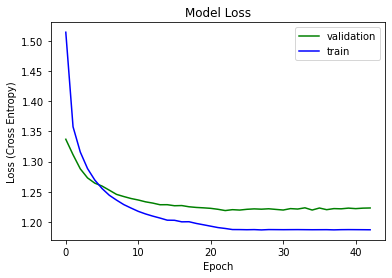

In [27]:
##### Plot loss ----

plt.plot(baseline_test_loss, '-g', label='validation')
plt.plot(baseline_train_loss, '-b', label='train')
plt.legend();
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy)");

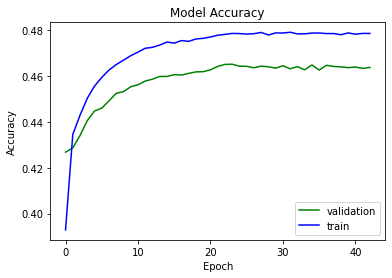

In [28]:
##### Plot accuracy ----

plt.plot(baseline_test_accuracy, '-g', label='validation')
plt.plot(baseline_train_accuracy, '-b', label='train')
plt.legend();
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy");

### Evaluation

In [29]:
##### Model evaluation -----

with torch.no_grad():

  # load in input and target data in batch
  inputs = torch.FloatTensor(x_validation_transformed).to(device)
  target = y_validation.to_numpy()

  # predict the test data
  y_pred = baseline_clf(inputs).cpu().detach().numpy().argmax(1)

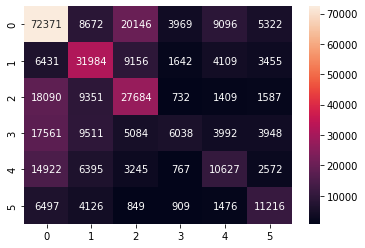

In [30]:
##### Confusion Matrix -----

from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(target, y_pred))

sns.heatmap(confusion_matrix_df, annot=True,fmt='g')

In [31]:
##### Classification Report -----

print(classification_report(target, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.5326    0.6052    0.5666    119576
           1     0.4567    0.5633    0.5044     56777
           2     0.4184    0.4704    0.4429     58853
           3     0.4295    0.1309    0.2006     46134
           4     0.3461    0.2758    0.3070     38528
           5     0.3991    0.4473    0.4219     25073

    accuracy                         0.4636    344941
   macro avg     0.4304    0.4155    0.4072    344941
weighted avg     0.4563    0.4636    0.4468    344941

